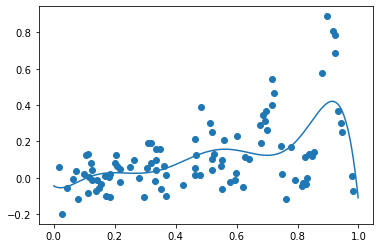

>x=0.279, f()=0.025232, actual=-0.036
>x=0.775, f()=0.169683, actual=0.091
>x=0.924, f()=0.416706, actual=0.502
>x=0.162, f()=0.023534, actual=0.008
>x=0.427, f()=0.093883, actual=-0.024
>x=0.915, f()=0.427842, actual=0.806
>x=0.914, f()=0.459577, actual=0.533
>x=0.885, f()=0.431029, actual=0.675
>x=0.909, f()=0.479585, actual=0.840
>x=0.507, f()=0.149257, actual=0.353
>x=0.917, f()=0.506179, actual=0.838
>x=0.807, f()=0.247089, actual=0.156
>x=0.934, f()=0.502357, actual=0.350
>x=0.904, f()=0.511853, actual=0.865
>x=0.912, f()=0.537079, actual=0.771
>x=0.927, f()=0.537365, actual=0.517
>x=0.866, f()=0.451085, actual=0.210
>x=0.101, f()=-0.000562, actual=0.119
>x=0.876, f()=0.473728, actual=0.506
>x=0.917, f()=0.541303, actual=0.881
>x=0.916, f()=0.557293, actual=0.802
>x=0.913, f()=0.567913, actual=0.678
>x=0.921, f()=0.570107, actual=0.610
>x=0.927, f()=0.565083, actual=0.641
>x=0.913, f()=0.576999, actual=0.709
>x=0.917, f()=0.582159, actual=0.794
>x=0.916, f()=0.589877, actual=0.68

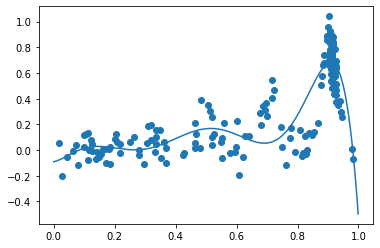

Best Result: x=0.904, y=1.042


In [1]:
# example of bayesian optimization for a 1d function from scratch
from math import sin
from math import pi
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from numpy.random import random
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot

# objective function
def objective(x, noise=0.1):
	noise = normal(loc=0, scale=noise)
	return (x**2 * sin(5 * pi * x)**6.0) + noise

# surrogate or approximation for the objective function
def surrogate(model, X):
	# catch any warning generated when making a prediction
	with catch_warnings():
		# ignore generated warnings
		simplefilter("ignore")
		return model.predict(X, return_std=True)

# probability of improvement acquisition function
def acquisition(X, Xsamples, model):
	# calculate the best surrogate score found so far
	yhat, _ = surrogate(model, X)
	best = max(yhat)
	# calculate mean and stdev via surrogate function
	mu, std = surrogate(model, Xsamples)
	mu = mu[:, 0]
	# calculate the probability of improvement
	probs = norm.cdf((mu - best) / (std+1E-9))
	return probs

# optimize the acquisition function
def opt_acquisition(X, y, model):
	# random search, generate random samples
	Xsamples = random(100)
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	# calculate the acquisition function for each sample
	scores = acquisition(X, Xsamples, model)
	# locate the index of the largest scores
	ix = argmax(scores)
	return Xsamples[ix, 0]

# plot real observations vs surrogate function
def plot(X, y, model):
	# scatter plot of inputs and real objective function
	pyplot.scatter(X, y)
	# line plot of surrogate function across domain
	Xsamples = asarray(arange(0, 1, 0.001))
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	ysamples, _ = surrogate(model, Xsamples)
	pyplot.plot(Xsamples, ysamples)
	# show the plot
	pyplot.show()

# sample the domain sparsely with noise
X = random(100)
y = asarray([objective(x) for x in X])
# reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)
# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)
# plot before hand
plot(X, y, model)
# perform the optimization process
for i in range(100):
	# select the next point to sample
	x = opt_acquisition(X, y, model)
	# sample the point
	actual = objective(x)
	# summarize the finding
	est, _ = surrogate(model, [[x]])
	print('>x=%.3f, f()=%3f, actual=%.3f' % (x, est, actual))
	# add the data to the dataset
	X = vstack((X, [[x]]))
	y = vstack((y, [[actual]]))
	# update the model
	model.fit(X, y)

# plot all samples and the final surrogate function
plot(X, y, model)
# best result
ix = argmax(y)
print('Best Result: x=%.3f, y=%.3f' % (X[ix], y[ix]))